In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Processing Aruba



In [ ]:
import pandas as pd
import numpy

In [ ]:
path = "/content/drive/My Drive/IP Data/data"
f = open(path)
f = f.read().split("\n")
st = "Meal_Preparation Relax Eating Work Sleeping Wash_Dishes Bed_to_Toilet Enter_Home Leave_Home Housekeeping Resperate".split(" ")

In [ ]:
data = []
for i in range(len(f)):
    dataExample = f[i]
    
    a = dataExample.replace('\t', ' ').replace('\n', ' ').split(" ")
    ar = []
    for i in a:
        if i:
            ar.append(i)
    if len(ar) == 4:
        ar.append("NoAction")
    elif len(ar)>4:
        temp = " ".join(ar[4:])
        ar = ar[:4] + [temp]
    else:
        print(i,dataExample)
    
    if ar != []:
        data.append(ar)

In [ ]:
loc = {
       "T001":"Bedroom","T002":"Living","T003":"Kitchen","T004":"Closet","T005":"Office",
       "M001":"Bedroom","M002":"Bedroom","M003":"Bedroom","M004":"Bathroom","M005":"Bedroom",
       "M006":"Bedroom","M007":"Bedroom","M008":"Living","M009":"Living","M010":"Living",
       "M011":"FrontDoor","M012":"Living","M013":"Living","M014":"Dining","M015":"Kitchen",
       "M016":"BackDoor","M017":"Kitchen","M018":"Kitchen","M019":"Kitchen","M020":"Living",
       "M021":"Path","M022":"Path","M023":"Bedroom","M024":"Bedroom","M025":"Office",
       "M026":"Office","M027":"Office","M028":"Office","M029":"Bathroom","M030":"GarageDoor",
       "M031":"Closet","D001":"FrontDoor","D002":"BackDoor","D003":"Closet","D004":"GarageDoor"  
      }

In [ ]:
for i in range(len(data)):
    if data[i][3] == "ON":
        data[i].append(loc[data[i][2]])
    else:
        data[i].append(data[i-1][5])

In [ ]:
DataNew = []
for i in data:
    if i[4] != "NoAction":
        DataNew.append([i[0],i[1],i[5],i[4]])
data = DataNew

In [ ]:
data = numpy.array(DataNew)
data = pd.DataFrame(data)
data.to_csv("DataAruba.csv", index=False, header=False)

# Action Model Aruba


In [ ]:
import numpy
import pandas as pd
import keras

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from sklearn.metrics import classification_report, f1_score
from tensorflow.keras import backend as K

In [ ]:
def to_one(arr):
  vals = list(set(arr))
  ar = []
  for i in range(len(arr)):
    ar.append(vals.index(arr[i]))
  return to_categorical(ar),vals

In [ ]:
d = pd.read_csv("DataAruba.csv", header=None).to_numpy()
data = []
day = []
time = []
hour = []
minute = []
loct = []
prevAct = []
y = []
for i in range(1,len(d)):
  if d[i][3] != "NoAction":
    data.append( [d[i][1], d[i][2][:5], d[i][3], d[i-1][4]] )
    t = d[i][2][:5]
    if t[-1] == ":":
      t = t[:-1]
    day.append(d[i][1])
    time.append(t)
    colon = t.find(':')
    hour.append(int(t[:colon]))
    minute.append(int(t[colon+1:]))
    loct.append(d[i][3])
    if len(y)==0:
      prevAct.append("Sleeping begin")
    else:
      prevAct.append(y[-1])
    y.append(d[i][4])
hour = numpy.array(hour)
minute = numpy.array(minute)

In [ ]:
print(hour.shape)
print(minute.shape)
time = hour*60 + minute
time = numpy.reshape(time,(time.shape[0],1))
print(time.shape)

(12953,)
(12953,)
(12953, 1)


In [ ]:
day, _ = to_one(day)
loct, _ = to_one(loct)
prevAct, vals = to_one(prevAct)
hour, _ = to_one(hour)
minute, _ = to_one(minute)
Y = []
for i in range(len(y)):
  Y.append(vals.index(y[i]))
Y = to_categorical(Y)

In [ ]:
print(hour.shape)

(12953, 24)


In [ ]:
trainEnd = 8000
valEnd = 10000
trainX = [day[:trainEnd],loct[:trainEnd],hour[:trainEnd],minute[:trainEnd],prevAct[:trainEnd],time[:trainEnd]]
#trainX = [day[:trainEnd],loct[:trainEnd],hour[:trainEnd],prevAct[:trainEnd],time[:trainEnd]]

trainY = Y[:trainEnd]
valX = [day[trainEnd:valEnd],loct[trainEnd:valEnd],hour[trainEnd:valEnd],minute[trainEnd:valEnd],prevAct[trainEnd:valEnd],time[trainEnd:valEnd]]
#valX = [day[trainEnd:valEnd],loct[trainEnd:valEnd],hour[trainEnd:valEnd],prevAct[trainEnd:valEnd],time[trainEnd:valEnd]]

valY = Y[trainEnd:valEnd]
testX = [day[valEnd:],loct[valEnd:],hour[valEnd:],minute[valEnd:],prevAct[valEnd:],time[valEnd:]]
#testX = [day[valEnd:],loct[valEnd:],hour[valEnd:],prevAct[valEnd:],time[valEnd:]]

testY = Y[valEnd:]

In [ ]:
print(day.shape,loct.shape,hour.shape,minute.shape,prevAct.shape,Y.shape)

(12953, 7) (12953, 11) (12953, 24) (12953, 60) (12953, 22) (12953, 22)


In [ ]:
Days = Input(shape=(7,))
Locts = Input(shape=(11,))
PrevActs = Input(shape=(22,))
Hours = Input(shape=(24,))
Minutes = Input(shape=(60,))
Time = Input(shape=(1,))


Day = Dense(8, activation="relu", input_shape=(7,))(Days)

Loct = Dense(8, activation="relu", input_shape=(11,))(Locts)

PrevAct = Dense(8, activation="relu")(PrevActs)

Hour = Dense(8, activation="relu", input_shape=(24,))(Hours)
Minute = Dense(8, activation="relu", input_shape=(60,))(Minutes)
#Time = concatenate([Hour, Minute])
Time1 = Dense(8, activation="relu", input_shape=(1,))(Time)


X = concatenate([Day, Loct, Time1, PrevAct, Hour, Minute])
#X = concatenate([Day, Loct, Time1, PrevAct, Hour])

att = Attention()([X,X])
print(att.shape)

X = Dense(8, activation="relu")(X)
y = Dense(22, activation="softmax")(X)

model = Model(inputs=[Days, Locts, Hours, Minutes, PrevActs, Time], outputs=y)
#model = Model(inputs=[Days, Locts, Hours, PrevActs, Time], outputs=y)

opt = Adam(lr=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

(None, 48)


In [ ]:
mc = ModelCheckpoint('Best_Model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
history = model.fit(
    trainX, trainY, validation_data=(valX, valY), batch_size=64,
    epochs=100, callbacks=[mc], verbose=0)

In [ ]:
model = load_model("Best_Model.h5")
Ypred1 = model.predict(valX)
Yp = numpy.argmax(Ypred1,axis=1)
Ya = numpy.argmax(valY,axis=1)
YP = []
YA = []
for i in range(len(Yp)):
  YP.append(vals[Yp[i]])
  YA.append(vals[Ya[i]])
print(classification_report(YA,YP))
print("Micro F1-Score:",f1_score(YA,YP,average='micro'))
print("Macro F1-Score:",f1_score(YA,YP,average='macro'))
print("Weighted F1-Score:",f1_score(YA,YP,average='weighted'))

                        precision    recall  f1-score   support

   Bed_to_Toilet begin       0.96      1.00      0.98        26
     Bed_to_Toilet end       1.00      1.00      1.00        26
          Eating begin       0.91      0.88      0.89        33
            Eating end       0.88      0.91      0.90        33
      Enter_Home begin       1.00      1.00      1.00        49
        Enter_Home end       1.00      1.00      1.00        48
      Housekeeping end       0.00      0.00      0.00         0
      Leave_Home begin       0.87      0.92      0.89        49
        Leave_Home end       1.00      1.00      1.00        49
Meal_Preparation begin       0.98      0.96      0.97       285
  Meal_Preparation end       0.96      0.96      0.96       286
           Relax begin       0.98      0.99      0.98       470
             Relax end       0.98      0.97      0.97       470
       Respirate begin       0.00      0.00      0.00         1
         Respirate end       0.00      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model = load_model("Best_Model.h5")
Ypred1 = model.predict(testX)
Yp = numpy.argmax(Ypred1,axis=1)
Ya = numpy.argmax(testY,axis=1)
YP = []
YA = []
for i in range(len(Yp)):
  YP.append(vals[Yp[i]])
  YA.append(vals[Ya[i]])
print(classification_report(YA,YP))
print("Micro F1-Score:",f1_score(YA,YP,average='micro'))
print("Macro F1-Score:",f1_score(YA,YP,average='macro'))
print("Weighted F1-Score:",f1_score(YA,YP,average='weighted'))

                        precision    recall  f1-score   support

   Bed_to_Toilet begin       1.00      1.00      1.00        27
     Bed_to_Toilet end       1.00      1.00      1.00        27
          Eating begin       0.94      0.85      0.89        39
            Eating end       0.82      0.82      0.82        39
      Enter_Home begin       1.00      0.99      1.00       118
        Enter_Home end       1.00      0.99      1.00       119
      Housekeeping end       0.00      0.00      0.00         0
      Leave_Home begin       0.99      0.91      0.95       118
        Leave_Home end       1.00      1.00      1.00       118
Meal_Preparation begin       0.97      0.98      0.98       378
  Meal_Preparation end       0.97      0.98      0.97       378
           Relax begin       0.99      0.99      0.99       655
             Relax end       1.00      1.00      1.00       655
       Respirate begin       0.00      0.00      0.00         2
         Respirate end       1.00      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


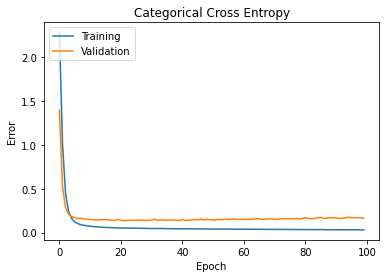

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Categorical Cross Entropy')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
print(len(trainX))
print(len(valX))
print(len(testX))

5
5
5


In [ ]:
trainset = trainX[0]
for i in range(1,len(trainX)):
  print(trainset.shape)
  print(trainX[i].shape)
  trainset = numpy.concatenate((trainset,trainX[i]),axis=1)

valset = valX[0]
for i in range(1,len(valX)):
  print(valset.shape)
  print(valX[i].shape)
  valset = numpy.concatenate((valset,valX[i]),axis=1)

testset = testX[0]
for i in range(1,len(testX)):
  print(testset.shape)
  print(testX[i].shape)
  testset = numpy.concatenate((testset,testX[i]),axis=1)

print(trainset.shape)
print(valset.shape)
print(testset.shape)

(8000, 7)
(8000, 11)
(8000, 18)
(8000, 24)
(8000, 42)
(8000, 60)
(8000, 102)
(8000, 22)
(8000, 124)
(8000, 1)
(2000, 7)
(2000, 11)
(2000, 18)
(2000, 24)
(2000, 42)
(2000, 60)
(2000, 102)
(2000, 22)
(2000, 124)
(2000, 1)
(2953, 7)
(2953, 11)
(2953, 18)
(2953, 24)
(2953, 42)
(2953, 60)
(2953, 102)
(2953, 22)
(2953, 124)
(2953, 1)
(8000, 125)
(2000, 125)
(2953, 125)


In [ ]:
X = Input(shape=(125,))

H1 = Dense(32, activation="relu", input_shape=(7,))(X)

H2 = Dense(12, activation="relu")(H1)
y = Dense(22, activation="softmax")(H2)

model = Model(inputs=X, outputs=y)

opt = Adam(lr=0.0005)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
mc = ModelCheckpoint('Best_Model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
history = model.fit(
    trainset, trainY, validation_data=(valset, valY), batch_size=256,
    epochs=100, callbacks=[mc], verbose=0)

In [ ]:
model = load_model("Best_Model.h5")
Ypred1 = model.predict(valset)
Yp = numpy.argmax(Ypred1,axis=1)
Ya = numpy.argmax(valY,axis=1)
YP = []
YA = []
for i in range(len(Yp)):
  YP.append(vals[Yp[i]])
  YA.append(vals[Ya[i]])
print(classification_report(YA,YP))
print("Micro F1-Score:",f1_score(YA,YP,average='micro'))
print("Macro F1-Score:",f1_score(YA,YP,average='macro'))
print("Weighted F1-Score:",f1_score(YA,YP,average='weighted'))

                        precision    recall  f1-score   support

   Bed_to_Toilet begin       0.96      1.00      0.98        26
     Bed_to_Toilet end       1.00      1.00      1.00        26
          Eating begin       0.89      1.00      0.94        33
            Eating end       0.88      0.91      0.90        33
      Enter_Home begin       1.00      1.00      1.00        49
        Enter_Home end       0.96      0.98      0.97        48
      Leave_Home begin       0.79      0.92      0.85        49
        Leave_Home end       1.00      1.00      1.00        49
Meal_Preparation begin       0.99      0.97      0.98       285
  Meal_Preparation end       0.96      0.96      0.96       286
           Relax begin       0.98      0.98      0.98       470
             Relax end       0.97      0.98      0.97       470
       Respirate begin       0.00      0.00      0.00         1
         Respirate end       0.00      0.00      0.00         1
        Sleeping begin       0.96      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model = load_model("Best_Model.h5")
Ypred1 = model.predict(testset)
Yp = numpy.argmax(Ypred1,axis=1)
Ya = numpy.argmax(testY,axis=1)
YP = []
YA = []
for i in range(len(Yp)):
  YP.append(vals[Yp[i]])
  YA.append(vals[Ya[i]])
print(classification_report(YA,YP))
print("Micro F1-Score:",f1_score(YA,YP,average='micro'))
print("Macro F1-Score:",f1_score(YA,YP,average='macro'))
print("Weighted F1-Score:",f1_score(YA,YP,average='weighted'))

                        precision    recall  f1-score   support

   Bed_to_Toilet begin       0.90      1.00      0.95        27
     Bed_to_Toilet end       0.90      1.00      0.95        27
          Eating begin       0.87      0.85      0.86        39
            Eating end       0.79      0.79      0.79        39
      Enter_Home begin       1.00      0.96      0.98       118
        Enter_Home end       1.00      0.98      0.99       119
      Leave_Home begin       0.79      0.91      0.85       118
        Leave_Home end       0.99      1.00      1.00       118
Meal_Preparation begin       0.97      0.99      0.98       378
  Meal_Preparation end       0.96      0.97      0.97       378
           Relax begin       0.99      0.99      0.99       655
             Relax end       0.99      1.00      0.99       655
       Respirate begin       0.00      0.00      0.00         2
         Respirate end       0.00      0.00      0.00         2
        Sleeping begin       0.98      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Data Processing Milan


In [ ]:
import pandas as pd
import numpy

In [ ]:
f = open("data")
f = f.read().split("\n")

In [ ]:
data = []
for i in range(len(f)):
    dataExample = f[i]
    
    a = dataExample.replace('\t', ' ').replace('\n', ' ').split(" ")
    ar = []
    for i in a:
        if i:
            ar.append(i)
    if len(ar) == 4:
        ar.append("NoAction")
    elif len(ar)>4:
        temp = " ".join(ar[4:])
        ar = ar[:4] + [temp]
    else:
        print(i,dataExample)
    
    if ar != []:
        data.append(ar)

 2009-10-24 


In [ ]:
DataNew = []
for ii in range(len(data)):
  i = data[ii]
  try:
    if i[4] != "NoAction":
      DataNew.append([i[0],i[1],i[2],i[4]])
  except:
    print(ii,i)
data = DataNew

58904 ['2009-10-24']


In [ ]:
data = numpy.array(DataNew)
data = pd.DataFrame(data)
data.to_csv("DataMilan.csv", index=False, header=False)

# Action Model Milan

In [ ]:
import numpy
import pandas as pd
import keras

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from sklearn.metrics import classification_report, f1_score
from tensorflow.keras import backend as K

In [ ]:
def to_one(arr):
  vals = list(set(arr))
  ar = []
  for i in range(len(arr)):
    ar.append(vals.index(arr[i]))
  return to_categorical(ar),vals

In [ ]:
d = pd.read_csv("DataMilan.csv", header=None).to_numpy()
data = []
day = []
time = []
hour = []
minute = []
loct = []
prevAct = []
y = []
for i in range(1,len(d)):
  if d[i][4] != "NoAction":
    data.append( [d[i][1], d[i][2][:5], d[i][3], d[i-1][4]] )
    t = d[i][2][:5]
    if t[-1] == ":":
      t = t[:-1]
    day.append(d[i][1])
    time.append(t)
    colon = t.find(':')
    hour.append(int(t[:colon]))
    minute.append(int(t[colon+1:]))
    loct.append(d[i][3])
    if len(y)==0:
      prevAct.append("Sleeping begin")
    else:
      prevAct.append(y[-1])
    y.append(d[i][4])
hour = numpy.array(hour)
minute = numpy.array(minute)

In [ ]:
print(hour.shape)
print(minute.shape)
time = hour*60 + minute
time = numpy.reshape(time,(time.shape[0],1))
print(time.shape)

(526,)
(526,)
(526, 1)


In [ ]:
day, _ = to_one(day)
loct, _ = to_one(loct)
prevAct, vals = to_one(prevAct)
hour, _ = to_one(hour)
minute, _ = to_one(minute)
Y = []
for i in range(len(y)):
  Y.append(vals.index(y[i]))
Y = to_categorical(Y)

In [ ]:
print(day.shape,loct.shape,hour.shape,minute.shape,prevAct.shape,Y.shape)

(526, 7) (526, 28) (526, 22) (526, 60) (526, 27) (526, 27)


In [ ]:
trainEnd = 350
valEnd = 400
trainX = [day[:trainEnd],loct[:trainEnd],hour[:trainEnd],minute[:trainEnd],prevAct[:trainEnd],time[:trainEnd]]
#trainX = [loct[:trainEnd],hour[:trainEnd],minute[:trainEnd],prevAct[:trainEnd],time[:trainEnd]]

trainY = Y[:trainEnd]
valX = [day[trainEnd:valEnd],loct[trainEnd:valEnd],hour[trainEnd:valEnd],minute[trainEnd:valEnd],prevAct[trainEnd:valEnd],time[trainEnd:valEnd]]
#valX = [loct[trainEnd:valEnd],hour[trainEnd:valEnd],minute[trainEnd:valEnd],prevAct[trainEnd:valEnd],time[trainEnd:valEnd]]

valY = Y[trainEnd:valEnd]
testX = [day[valEnd:],loct[valEnd:],hour[valEnd:],minute[valEnd:],prevAct[valEnd:],time[valEnd:]]
#testX = [loct[valEnd:],hour[valEnd:],minute[valEnd:],prevAct[valEnd:],time[valEnd:]]
testY = Y[valEnd:]

In [ ]:
#Days = Input(shape=(7,))
Locts = Input(shape=(28,))
PrevActs = Input(shape=(27,))
Hours = Input(shape=(22,))
Minutes = Input(shape=(60,))
Time = Input(shape=(1,))

#Day = Dense(10, activation="relu", input_shape=(7,))(Days)

Loct = Dense(10, activation="relu", input_shape=(11,))(Locts)

PrevAct = Dense(10, activation="relu")(PrevActs)

Hour = Dense(8, activation="relu", input_shape=(22,))(Hours)
Minute = Dense(8, activation="relu", input_shape=(60,))(Minutes)
Time1 = Dense(8, activation="relu", input_shape=(1,))(Time)
#Time = concatenate([Hour, Minute])
#Time = Dense(10, activation="relu")(Time)

#X = concatenate([Day, Loct, Hour,Minute, PrevAct, Time1])
X = concatenate([Loct, Hour,Minute, PrevAct, Time1])

X = Dense(64, activation="relu")(X)
y = Dense(27, activation="softmax")(X)

#model = Model(inputs=[Days, Locts, Hours, Minutes, PrevActs,Time], outputs=y)
model = Model(inputs=[Locts, Hours, Minutes, PrevActs,Time], outputs=y)

opt = Adam(lr=0.005)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
mc = ModelCheckpoint('Best_Model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
history = model.fit(
    trainX, trainY, validation_data=(valX, valY), batch_size=64,
    epochs=200, callbacks=[mc], verbose=0)

In [ ]:
model = load_model("Best_Model.h5")
Ypred1 = model.predict(valX)
Yp = numpy.argmax(Ypred1,axis=1)
Ya = numpy.argmax(valY,axis=1)
YP = []
YA = []
for i in range(len(Yp)):
  YP.append(vals[Yp[i]])
  YA.append(vals[Ya[i]])
print(classification_report(YA,YP))
print("Micro F1-Score:",f1_score(YA,YP,average='micro'))
print("Macro F1-Score:",f1_score(YA,YP,average='macro'))
print("Weighted F1-Score:",f1_score(YA,YP,average='weighted'))

                        precision    recall  f1-score   support

   Bed_to_Toilet begin       0.50      0.50      0.50         2
     Bed_to_Toilet end       1.00      1.00      1.00         2
          Chores begin       0.50      0.33      0.40         3
            Chores end       0.75      1.00      0.86         3
   Desk_Activity begin       1.00      1.00      1.00         1
     Desk_Activity end       1.00      1.00      1.00         1
  Guest_Bathroom begin       1.00      1.00      1.00         1
    Guest_Bathroom end       1.00      1.00      1.00         1
Kitchen_Activity begin       0.67      0.50      0.57         4
  Kitchen_Activity end       0.60      0.75      0.67         4
      Leave_Home begin       1.00      0.67      0.80         3
        Leave_Home end       1.00      1.00      1.00         3
 Master_Bathroom begin       0.83      1.00      0.91         5
   Master_Bathroom end       1.00      1.00      1.00         5
    Morning_Meds begin       1.00      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model = load_model("Best_Model.h5")
Ypred1 = model.predict(testX)
Yp = numpy.argmax(Ypred1,axis=1)
Ya = numpy.argmax(testY,axis=1)
YP = []
YA = []
for i in range(len(Yp)):
  YP.append(vals[Yp[i]])
  YA.append(vals[Ya[i]])
print(classification_report(YA,YP))
print("Micro F1-Score:",f1_score(YA,YP,average='micro'))
print("Macro F1-Score:",f1_score(YA,YP,average='macro'))
print("Weighted F1-Score:",f1_score(YA,YP,average='weighted'))

                        precision    recall  f1-score   support

   Bed_to_Toilet begin       1.00      0.33      0.50         6
     Bed_to_Toilet end       1.00      0.67      0.80         6
          Chores begin       0.00      0.00      0.00         2
            Chores end       0.50      0.50      0.50         2
   Desk_Activity begin       1.00      1.00      1.00         1
     Desk_Activity end       1.00      1.00      1.00         1
  Guest_Bathroom begin       0.00      0.00      0.00         1
    Guest_Bathroom end       0.50      1.00      0.67         1
Kitchen_Activity begin       0.67      0.80      0.73        10
  Kitchen_Activity end       0.91      1.00      0.95        10
      Leave_Home begin       0.93      1.00      0.96        13
        Leave_Home end       1.00      1.00      1.00        13
 Master_Bathroom begin       1.00      1.00      1.00         8
   Master_Bathroom end       1.00      1.00      1.00         8
        Meditate begin       1.00      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


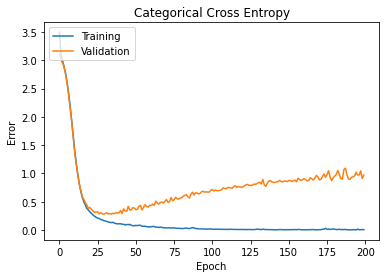

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Categorical Cross Entropy')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
trainset = trainX[0]
for i in range(1,len(trainX)):
  print(trainset.shape)
  print(trainX[i].shape)
  trainset = numpy.concatenate((trainset,trainX[i]),axis=1)

valset = valX[0]
for i in range(1,len(valX)):
  print(valset.shape)
  print(valX[i].shape)
  valset = numpy.concatenate((valset,valX[i]),axis=1)

testset = testX[0]
for i in range(1,len(testX)):
  print(testset.shape)
  print(testX[i].shape)
  testset = numpy.concatenate((testset,testX[i]),axis=1)

print(trainset.shape)
print(valset.shape)
print(testset.shape)
print(trainY.shape)
print(valY.shape)

(350, 7)
(350, 28)
(350, 35)
(350, 22)
(350, 57)
(350, 60)
(350, 117)
(350, 27)
(350, 144)
(350, 1)
(50, 7)
(50, 28)
(50, 35)
(50, 22)
(50, 57)
(50, 60)
(50, 117)
(50, 27)
(50, 144)
(50, 1)
(126, 7)
(126, 28)
(126, 35)
(126, 22)
(126, 57)
(126, 60)
(126, 117)
(126, 27)
(126, 144)
(126, 1)
(350, 145)
(50, 145)
(126, 145)
(350, 27)
(50, 27)


In [ ]:
X = Input(shape=(145,))

H1 = Dense(64, activation="relu", input_shape=(7,))(X)

H2 = Dense(32, activation="relu")(H1)
y = Dense(27, activation="softmax")(H2)

model = Model(inputs=X, outputs=y)

opt = Adam(lr=0.002)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
mc = ModelCheckpoint('Best_Model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
history = model.fit(
    trainset, trainY, validation_data=(valset, valY), batch_size=64,
    epochs=100, callbacks=[mc], verbose=0)

In [ ]:
model = load_model("Best_Model.h5")
Ypred1 = model.predict(valset)
Yp = numpy.argmax(Ypred1,axis=1)
Ya = numpy.argmax(valY,axis=1)
YP = []
YA = []
for i in range(len(Yp)):
  YP.append(vals[Yp[i]])
  YA.append(vals[Ya[i]])
print(classification_report(YA,YP))
print("Micro F1-Score:",f1_score(YA,YP,average='micro'))
print("Macro F1-Score:",f1_score(YA,YP,average='macro'))
print("Weighted F1-Score:",f1_score(YA,YP,average='weighted'))

                        precision    recall  f1-score   support

   Bed_to_Toilet begin       0.00      0.00      0.00         2
     Bed_to_Toilet end       1.00      0.50      0.67         2
          Chores begin       0.00      0.00      0.00         3
            Chores end       1.00      1.00      1.00         3
   Desk_Activity begin       0.00      0.00      0.00         1
     Desk_Activity end       0.50      1.00      0.67         1
  Guest_Bathroom begin       0.00      0.00      0.00         1
    Guest_Bathroom end       1.00      1.00      1.00         1
Kitchen_Activity begin       0.80      1.00      0.89         4
  Kitchen_Activity end       1.00      0.75      0.86         4
      Leave_Home begin       0.50      0.67      0.57         3
        Leave_Home end       0.75      1.00      0.86         3
 Master_Bathroom begin       0.57      0.80      0.67         5
   Master_Bathroom end       0.71      1.00      0.83         5
    Morning_Meds begin       0.00      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model = load_model("Best_Model.h5")
Ypred1 = model.predict(testset)
Yp = numpy.argmax(Ypred1,axis=1)
Ya = numpy.argmax(testY,axis=1)
YP = []
YA = []
for i in range(len(Yp)):
  YP.append(vals[Yp[i]])
  YA.append(vals[Ya[i]])
print(classification_report(YA,YP))
print("Micro F1-Score:",f1_score(YA,YP,average='micro'))
print("Macro F1-Score:",f1_score(YA,YP,average='macro'))
print("Weighted F1-Score:",f1_score(YA,YP,average='weighted'))

                        precision    recall  f1-score   support

   Bed_to_Toilet begin       0.00      0.00      0.00         6
     Bed_to_Toilet end       1.00      0.67      0.80         6
          Chores begin       0.00      0.00      0.00         2
            Chores end       1.00      0.50      0.67         2
   Desk_Activity begin       0.00      0.00      0.00         1
     Desk_Activity end       0.50      1.00      0.67         1
  Guest_Bathroom begin       1.00      1.00      1.00         1
    Guest_Bathroom end       1.00      1.00      1.00         1
Kitchen_Activity begin       0.73      0.80      0.76        10
  Kitchen_Activity end       0.83      1.00      0.91        10
      Leave_Home begin       0.71      0.77      0.74        13
        Leave_Home end       0.86      0.92      0.89        13
 Master_Bathroom begin       0.89      1.00      0.94         8
   Master_Bathroom end       0.73      1.00      0.84         8
        Meditate begin       0.00      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Data Processing Tulum

In [ ]:
import pandas as pd
import numpy

In [ ]:
f = open("data")
f = f.read().split("\n")

In [ ]:
data = []
for ii in range(len(f)):
    dataExample = f[ii]
    
    a = dataExample.replace('\t', ' ').replace('\n', ' ').split(" ")
    ar = []
    for i in a:
        if i:
            ar.append(i)
    if len(ar) == 4:
        ar.append("NoAction")
    elif len(ar)>4:
        temp = " ".join(ar[4:])
        ar = ar[:4] + [temp]
    else:
        print(ii,dataExample)
    
    if ar != []:
        data.append(ar)

445632 2009-11-19 21:13:03.056227			ON
617394 2009-12-14 19:25:40.098519	 	ON
1085902 


In [ ]:
DataNew = []
for ii in range(len(data)):
  i = data[ii]
  try:
    if i[4] != "NoAction":
      DataNew.append([i[0],i[1],i[2],i[4]])
  except:
    print(ii,i)
data = DataNew

445632 ['2009-11-19', '21:13:03.056227', 'ON']
617394 ['2009-12-14', '19:25:40.098519', 'ON']


In [ ]:
data = numpy.array(DataNew)
data = pd.DataFrame(data)
data.to_csv("DataTulum.csv", index=False, header=False)

# Action Model Tulum

In [ ]:
import numpy
import pandas as pd
import keras

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from sklearn.metrics import classification_report, f1_score
from tensorflow.keras import backend as K

In [ ]:
def to_one(arr):
  vals = list(set(arr))
  ar = []
  for i in range(len(arr)):
    ar.append(vals.index(arr[i]))
  return to_categorical(ar),vals

In [ ]:
d = pd.read_csv("DataTulum.csv", header=None).to_numpy()
data = []
day = []
time = []
hour = []
minute = []
loct = []
prevAct = []
y = []
for i in range(1,len(d)):
  if d[i][4] != "NoAction":
    data.append( [d[i][1], d[i][2][:5], d[i][3], d[i-1][4]] )
    t = d[i][2][:5]
    if t[-1] == ":":
      t = t[:-1]
    day.append(d[i][1])
    time.append(t)
    colon = t.find(':')
    hour.append(int(t[:colon]))
    minute.append(int(t[colon+1:]))
    loct.append(d[i][3])
    if len(y)==0:
      prevAct.append("Sleeping begin")
    else:
      prevAct.append(y[-1])
    y.append(d[i][4])
hour = numpy.array(hour)
minute = numpy.array(minute)

In [ ]:
print(hour.shape)
print(minute.shape)
time = hour*60 + minute
time = numpy.reshape(time,(time.shape[0],1))
print(time.shape)

(25274,)
(25274,)
(25274, 1)


In [ ]:
loc = {
       "T001":"Kitchen","T002":"Living","T003":"Bedroom","T004":"Bedroom","T005":"Bath",
       "M001":"Entrance","M002":"Living","M003":"Kitchen","M004":"Stairs","M005":"Hallway",
       "M006":"Hallway","M007":"Living","M008":"Living","M009":"Living","M010":"Living",
       "M011":"Living","M012":"Living","M013":"Kitchen","M014":"Kitchen","M015":"Kitchen",
       "M016":"Kitchen","M017":"Bedroom","M018":"Bedroom","M019":"Bedroom","M020":"Bedroom",
       "M021":"Bedroom","M022":"Bedroom","M023":"Stairs","M024":"Door","M025":"Bath",
       "M026":"Bath","M027":"Bath","M028":"Bedroom","M029":"Bedroom","M030":"Bedroom",
       "M031":"Bedroom"  
      }

In [ ]:
for i in range(len(loct)):
  loct[i] = loc[loct[i]]

In [ ]:
day, _ = to_one(day)
loct, _ = to_one(loct)
prevAct, vals = to_one(prevAct)
hour, _ = to_one(hour)
minute, _ = to_one(minute)
Y = []
for i in range(len(y)):
  Y.append(vals.index(y[i]))
Y = to_categorical(Y)

In [ ]:
print(day.shape,loct.shape,hour.shape,minute.shape,prevAct.shape,Y.shape,time.shape)

(25274, 7) (25274, 8) (25274, 24) (25274, 60) (25274, 35) (25274, 35) (25274, 1)


In [ ]:
trainEnd = 16000
valEnd = 20000
trainX = [day[:trainEnd],loct[:trainEnd],hour[:trainEnd],minute[:trainEnd],prevAct[:trainEnd],time[:trainEnd]]
#trainX = [day[:trainEnd],loct[:trainEnd],hour[:trainEnd],minute[:trainEnd],prevAct[:trainEnd]]

trainY = Y[:trainEnd]
valX = [day[trainEnd:valEnd],loct[trainEnd:valEnd],hour[trainEnd:valEnd],minute[trainEnd:valEnd],prevAct[trainEnd:valEnd],time[trainEnd:valEnd]]
#valX = [day[trainEnd:valEnd],loct[trainEnd:valEnd],hour[trainEnd:valEnd],minute[trainEnd:valEnd],prevAct[trainEnd:valEnd]]

valY = Y[trainEnd:valEnd]
testX = [day[valEnd:],loct[valEnd:],hour[valEnd:],minute[valEnd:],prevAct[valEnd:],time[valEnd:]]
#testX = [day[valEnd:],loct[valEnd:],hour[valEnd:],minute[valEnd:],prevAct[valEnd:]]

testY = Y[valEnd:]

In [ ]:
Days = Input(shape=(7,))
Locts = Input(shape=(8,))
PrevActs = Input(shape=(35,))
Hours = Input(shape=(24,))
Minutes = Input(shape=(60,))
#Time = Input(shape=(1,))

Day = Dense(16, activation="relu", input_shape=(7,))(Days)

Loct = Dense(16, activation="relu", input_shape=(11,))(Locts)

PrevAct = Dense(16, activation="relu")(PrevActs)

Hour = Dense(16, activation="relu", input_shape=(24,))(Hours)
Minute = Dense(16, activation="relu", input_shape=(60,))(Minutes)
#Time = concatenate([Hour, Minute])
#Time = Dense(16, activation="relu")(Time)
#Time1 = Dense(16, activation="relu", input_shape=(1,))(Time)

X = concatenate([Day, Loct, Hour, Minute, PrevAct])

X = Dense(64, activation="relu")(X)
y = Dense(35, activation="softmax")(X)

model = Model(inputs=[Days, Locts, Hours, Minutes, PrevActs], outputs=y)
opt = Adam(lr=0.01)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
mc = ModelCheckpoint('Best_Model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
history = model.fit(
    trainX, trainY, validation_data=(valX, valY), batch_size=64,
    epochs=200, callbacks=[mc], verbose=0)

In [ ]:
model = load_model("Best_Model.h5")
Ypred1 = model.predict(valX)
Yp = numpy.argmax(Ypred1,axis=1)
Ya = numpy.argmax(valY,axis=1)
YP = []
YA = []
for i in range(len(Yp)):
  YP.append(vals[Yp[i]])
  YA.append(vals[Ya[i]])
print(classification_report(YA,YP))
print("Micro F1-Score:",f1_score(YA,YP,average='micro'))
print("Macro F1-Score:",f1_score(YA,YP,average='macro'))
print("Weighted F1-Score:",f1_score(YA,YP,average='weighted'))

                             precision    recall  f1-score   support

              Bathing begin       0.40      0.33      0.36        70
                Bathing end       0.83      0.75      0.79        69
Bed_Toilet_Transition begin       0.89      0.89      0.89        18
  Bed_Toilet_Transition end       1.00      1.00      1.00        18
               Eating begin       0.51      0.51      0.51        96
                 Eating end       1.00      0.94      0.97        96
           Enter_Home begin       1.00      0.93      0.97        15
             Enter_Home end       1.00      1.00      1.00        15
           Leave_Home begin       0.85      0.73      0.79        15
             Leave_Home end       1.00      1.00      1.00        15
     Meal_Preparation begin       0.67      0.76      0.71       359
       Meal_Preparation end       1.00      0.96      0.98       360
     Personal_Hygiene begin       0.68      0.79      0.73       188
       Personal_Hygiene end      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model = load_model("Best_Model.h5")
Ypred1 = model.predict(testX)
Yp = numpy.argmax(Ypred1,axis=1)
Ya = numpy.argmax(testY,axis=1)
YP = []
YA = []
for i in range(len(Yp)):
  YP.append(vals[Yp[i]])
  YA.append(vals[Ya[i]])
print(classification_report(YA,YP))
print("Micro F1-Score:",f1_score(YA,YP,average='micro'))
print("Macro F1-Score:",f1_score(YA,YP,average='macro'))
print("Weighted F1-Score:",f1_score(YA,YP,average='weighted'))

                             precision    recall  f1-score   support

              Bathing begin       0.31      0.43      0.36        82
                Bathing end       0.83      0.71      0.77        83
Bed_Toilet_Transition begin       1.00      0.96      0.98        23
  Bed_Toilet_Transition end       1.00      1.00      1.00        23
               Eating begin       0.30      0.42      0.35        71
                 Eating end       0.98      0.85      0.91        71
           Enter_Home begin       0.96      0.85      0.90        26
             Enter_Home end       1.00      1.00      1.00        26
           Leave_Home begin       0.58      0.96      0.72        26
             Leave_Home end       0.96      0.96      0.96        26
     Meal_Preparation begin       0.67      0.72      0.70       458
       Meal_Preparation end       0.99      0.93      0.96       458
     Personal_Hygiene begin       0.74      0.77      0.76       280
       Personal_Hygiene end      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


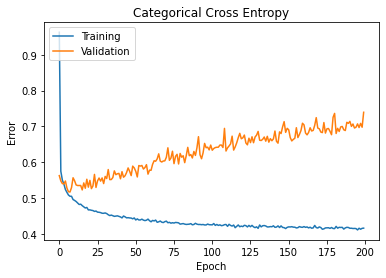

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Categorical Cross Entropy')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
trainset = trainX[0]
for i in range(1,len(trainX)):
  print(trainset.shape)
  print(trainX[i].shape)
  trainset = numpy.concatenate((trainset,trainX[i]),axis=1)

valset = valX[0]
for i in range(1,len(valX)):
  print(valset.shape)
  print(valX[i].shape)
  valset = numpy.concatenate((valset,valX[i]),axis=1)

testset = testX[0]
for i in range(1,len(testX)):
  print(testset.shape)
  print(testX[i].shape)
  testset = numpy.concatenate((testset,testX[i]),axis=1)

print(trainset.shape)
print(valset.shape)
print(testset.shape)
print(trainY.shape)
print(valY.shape)

(16000, 7)
(16000, 8)
(16000, 15)
(16000, 24)
(16000, 39)
(16000, 60)
(16000, 99)
(16000, 35)
(16000, 134)
(16000, 1)
(4000, 7)
(4000, 8)
(4000, 15)
(4000, 24)
(4000, 39)
(4000, 60)
(4000, 99)
(4000, 35)
(4000, 134)
(4000, 1)
(5274, 7)
(5274, 8)
(5274, 15)
(5274, 24)
(5274, 39)
(5274, 60)
(5274, 99)
(5274, 35)
(5274, 134)
(5274, 1)
(16000, 135)
(4000, 135)
(5274, 135)
(16000, 35)
(4000, 35)


In [ ]:
X = Input(shape=(135,))

H1 = Dense(36, activation="relu", input_shape=(7,))(X)

H2 = Dense(16, activation="relu")(H1)
y = Dense(35, activation="softmax")(H2)

model = Model(inputs=X, outputs=y)

opt = Adam(lr=0.0001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
mc = ModelCheckpoint('Best_Model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
history = model.fit(
    trainset, trainY, validation_data=(valset, valY), batch_size=128,
    epochs=100, callbacks=[mc], verbose=0)

In [ ]:
model = load_model("Best_Model.h5")
Ypred1 = model.predict(valset)
Yp = numpy.argmax(Ypred1,axis=1)
Ya = numpy.argmax(valY,axis=1)
YP = []
YA = []
for i in range(len(Yp)):
  YP.append(vals[Yp[i]])
  YA.append(vals[Ya[i]])
print(classification_report(YA,YP))
print("Micro F1-Score:",f1_score(YA,YP,average='micro'))
print("Macro F1-Score:",f1_score(YA,YP,average='macro'))
print("Weighted F1-Score:",f1_score(YA,YP,average='weighted'))

                             precision    recall  f1-score   support

              Bathing begin       0.55      0.23      0.32        70
                Bathing end       0.73      0.78      0.76        69
Bed_Toilet_Transition begin       1.00      0.67      0.80        18
  Bed_Toilet_Transition end       1.00      0.94      0.97        18
               Eating begin       0.78      0.33      0.47        96
                 Eating end       1.00      0.94      0.97        96
           Enter_Home begin       0.87      0.87      0.87        15
             Enter_Home end       1.00      0.73      0.85        15
           Leave_Home begin       0.00      0.00      0.00        15
             Leave_Home end       0.83      0.67      0.74        15
     Meal_Preparation begin       0.64      0.86      0.73       359
       Meal_Preparation end       0.98      0.96      0.97       360
     Personal_Hygiene begin       0.71      0.88      0.79       188
       Personal_Hygiene end      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model = load_model("Best_Model.h5")
Ypred1 = model.predict(testset)
Yp = numpy.argmax(Ypred1,axis=1)
Ya = numpy.argmax(testY,axis=1)
YP = []
YA = []
for i in range(len(Yp)):
  YP.append(vals[Yp[i]])
  YA.append(vals[Ya[i]])
print(classification_report(YA,YP))
print("Micro F1-Score:",f1_score(YA,YP,average='micro'))
print("Macro F1-Score:",f1_score(YA,YP,average='macro'))
print("Weighted F1-Score:",f1_score(YA,YP,average='weighted'))

                             precision    recall  f1-score   support

              Bathing begin       0.47      0.23      0.31        82
                Bathing end       0.62      0.75      0.68        83
Bed_Toilet_Transition begin       1.00      0.83      0.90        23
  Bed_Toilet_Transition end       0.95      0.87      0.91        23
               Eating begin       0.33      0.15      0.21        71
                 Eating end       0.98      0.85      0.91        71
           Enter_Home begin       0.81      0.85      0.83        26
             Enter_Home end       1.00      0.92      0.96        26
           Leave_Home begin       0.00      0.00      0.00        26
             Leave_Home end       0.81      0.85      0.83        26
     Meal_Preparation begin       0.65      0.75      0.70       458
       Meal_Preparation end       0.96      0.95      0.95       458
     Personal_Hygiene begin       0.74      0.86      0.80       280
       Personal_Hygiene end      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
